# Exploratory Data Analysis - Time Series of Precipitation
# And applying models
#  Mefalsim 2001-2020 - 3

## (1) Importing the relevant libraries

In [1]:
 # python libs
import sys
import numpy as np
import pandas as pd
import os
import datetime
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib

## (2) Reading the CSV file in to a DataSet

In [125]:
df=pd.read_csv("Mefalsim_preciption_2001-2020.csv")
df

,date,day_acu_precip
0,01/01/2001,0.087931
1,02/01/2001,9.049679
2,03/01/2001,0.000000
3,04/01/2001,0.057418
4,05/01/2001,0.504346
...,...,...
7300,27/12/2020,0.000000
7301,28/12/2020,0.004954
7302,29/12/2020,0.000000
7303,30/12/2020,0.000000


#### (2.1) Convert string date to datetime format

In [129]:
df['date'] = pd.to_datetime(df['date'])
print (df.dtypes)

date              datetime64[ns]
day_acu_precip           float64
dtype: object


In [275]:
    # Try to change to int64 values - not working wiht the models ahead
#df['date'] = pd.to_datetime(df['date']).astype('int64')/ 10**9
#print (df.dtypes)

In [130]:
df

,date,day_acu_precip
0,2001-01-01,0.087931
1,2001-02-01,9.049679
2,2001-03-01,0.000000
3,2001-04-01,0.057418
4,2001-05-01,0.504346
...,...,...
7300,2020-12-27,0.000000
7301,2020-12-28,0.004954
7302,2020-12-29,0.000000
7303,2020-12-30,0.000000


In [7]:
#( To see it All)
#pd.reset_option('^display.', silent=True)
#df

#### (2.2) Make date to index

In [131]:
df.set_index('date', inplace=True)

In [132]:
df

,day_acu_precip
date,
2001-01-01,0.087931
2001-02-01,9.049679
2001-03-01,0.000000
2001-04-01,0.057418
2001-05-01,0.504346
...,...
2020-12-27,0.000000
2020-12-28,0.004954
2020-12-29,0.000000


#### (2.3) Time Series Statistics

In [133]:
df.describe()

,day_acu_precip
count,7305.000000
mean,1.327926
std,7.528874
min,0.000000
25%,0.000000
50%,0.000000
75%,0.025765
max,250.592620


## (3) Visualization

### (3.1) The Data when using Seaborn

In [113]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
#from matplotlib import style

In [20]:
#df.plot(label='Precipitation')
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(20, 10)
#plt.legend()

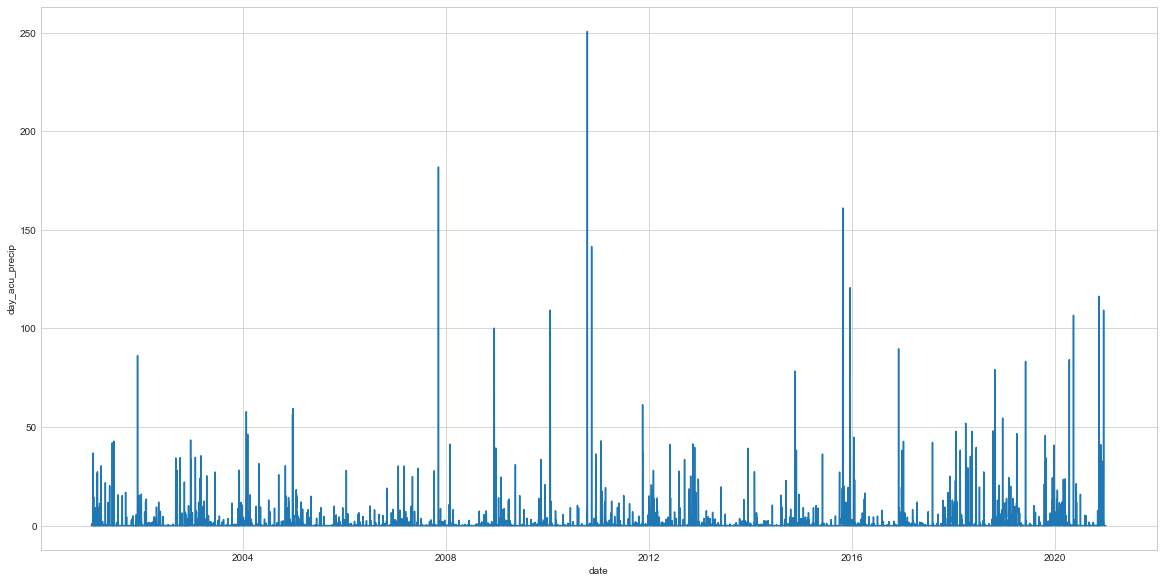

In [134]:
sns.lineplot(x=df.index, y="day_acu_precip", data=df)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)


### (3.2) Historgram

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


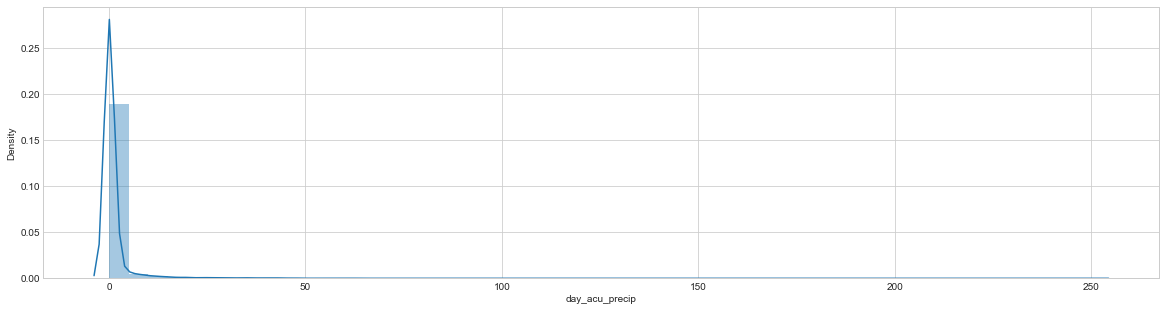

In [135]:
sns.distplot(df['day_acu_precip'])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 5)

## (4) Anomalies (Outliers) analysis
#### (4.1) Using ADTK tools

In [57]:
#import adtk.data
#from adtk.data import validate_series
#from adtk.visualization import plot
#from adtk.detector import *

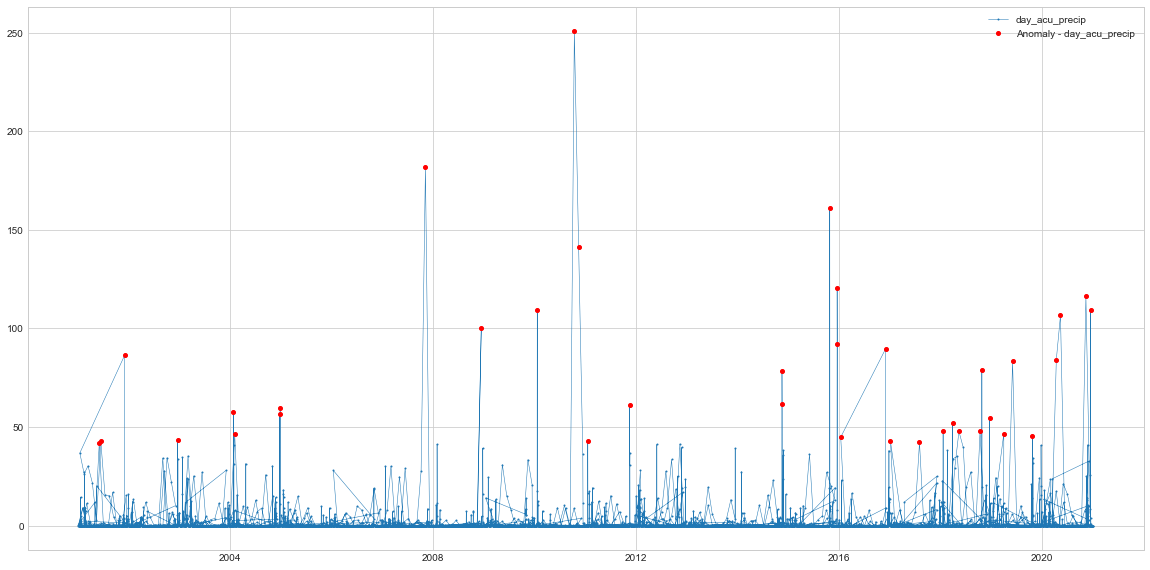

In [136]:
#from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.995, low=0.005)
anomalies = quantile_ad.fit_detect(df)
plot(df, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
plt.show()

### ( Red dots mark anomalies  >< 0.5% of the range ... no way to remove them)

#### (4.2) Try to use KMeans - somthing is worng
##### ( In literature values are normaly close to abouve)

In [69]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(df) for i in n_cluster]
scores = [kmeans[i].score(df) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

AttributeError: 'NoneType' object has no attribute 'split'

In [63]:
# Import necessary libraries
from sklearn.cluster import KMeans
# I will start k-means clustering with k=2 as I already know that there are 3 classes of "NORMAL" vs 
# "NOT NORMAL" which are combination of BROKEN" and"RECOVERING"
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df.values)
labels = kmeans.predict(df.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

In [68]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(df, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

KeyError: 0

## (5) Stationarity Test
### Time Series must be stationary for use in forcating models
#### To test stationarity Composition and Decomposition methods are used

### (5.1) Decomposition

In [197]:
## decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df,period=1 ,model='additive', extrapolate_trend='freq')

In [198]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [139]:
trend

date
2001-01-01    0.087931
2001-02-01    9.049679
2001-03-01    0.000000
2001-04-01    0.057418
2001-05-01    0.504346
                ...   
2020-12-27    0.000000
2020-12-28    0.004954
2020-12-29    0.000000
2020-12-30    0.000000
2020-12-31    0.000000
Name: trend, Length: 7305, dtype: float64

In [210]:
seasonal

date
2001-01-01    0.0
2001-02-01    0.0
2001-03-01    0.0
2001-04-01    0.0
2001-05-01    0.0
             ... 
2020-12-27    0.0
2020-12-28    0.0
2020-12-29    0.0
2020-12-30    0.0
2020-12-31    0.0
Name: seasonal, Length: 7305, dtype: float64

In [211]:
residual

date
2001-01-01    0.0
2001-02-01    0.0
2001-03-01    0.0
2001-04-01    0.0
2001-05-01    0.0
             ... 
2020-12-27    0.0
2020-12-28    0.0
2020-12-29    0.0
2020-12-30    0.0
2020-12-31    0.0
Name: resid, Length: 7305, dtype: float64

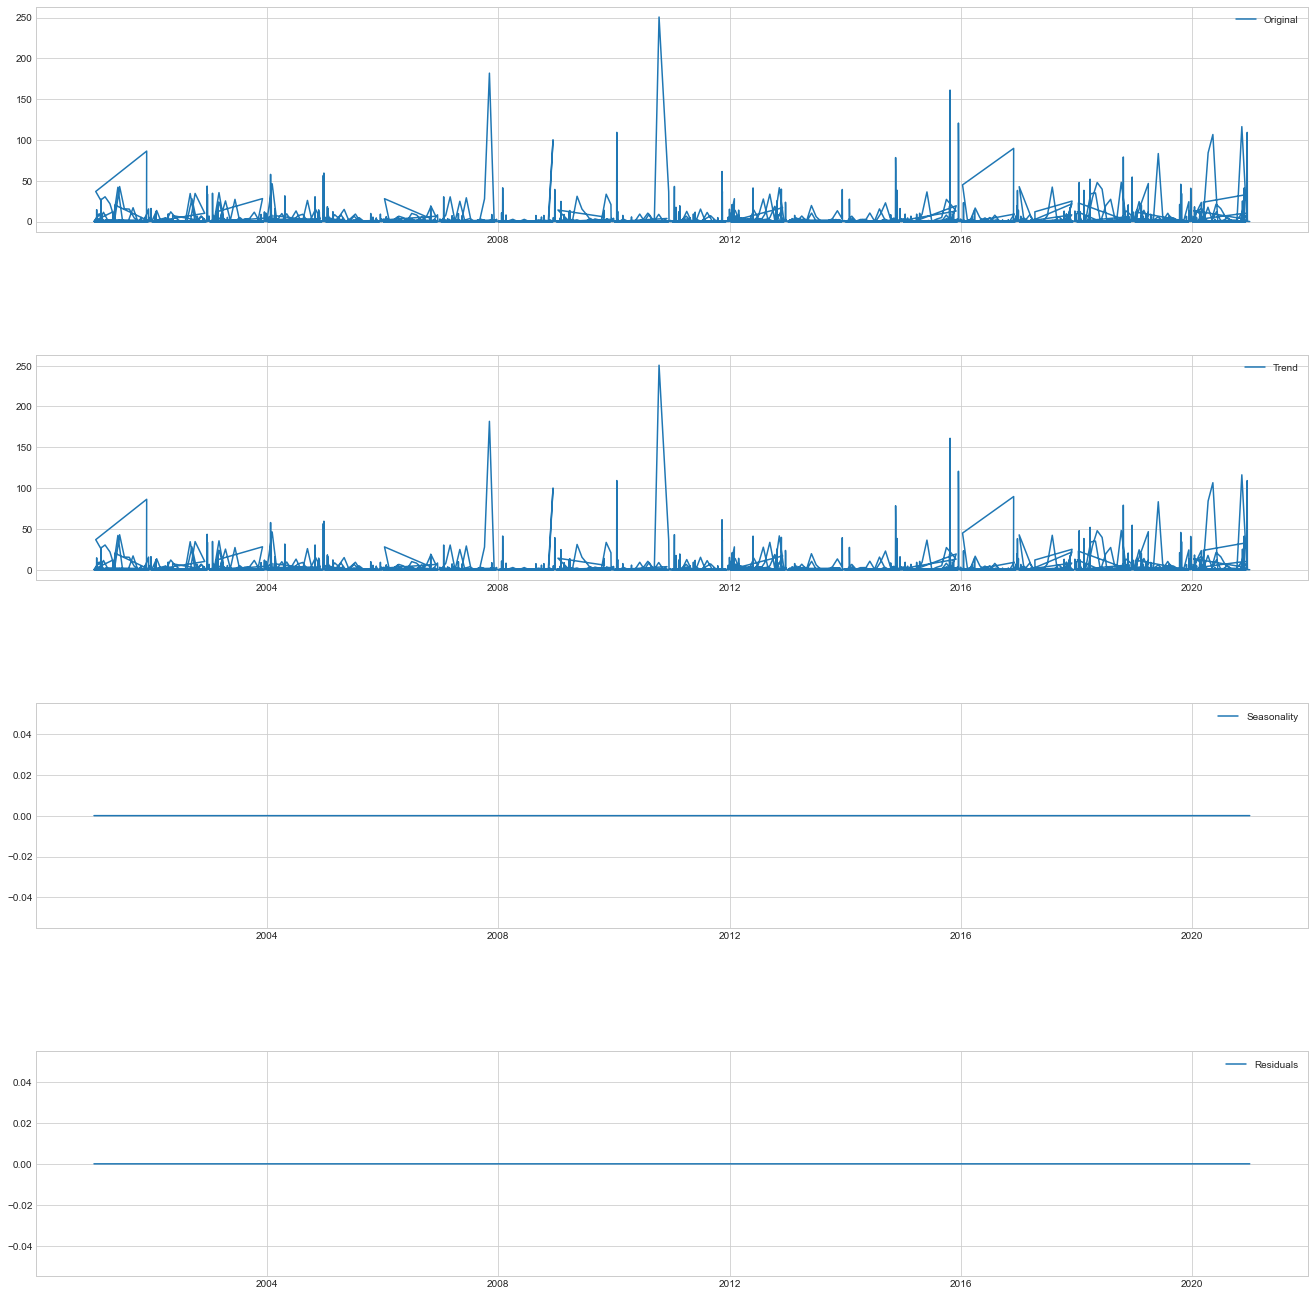

In [199]:
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)

### (5.2) Using STL lib to get season and residuals
#### Better resulst wiht this tool

In [238]:
from statsmodels.tsa.seasonal import STL

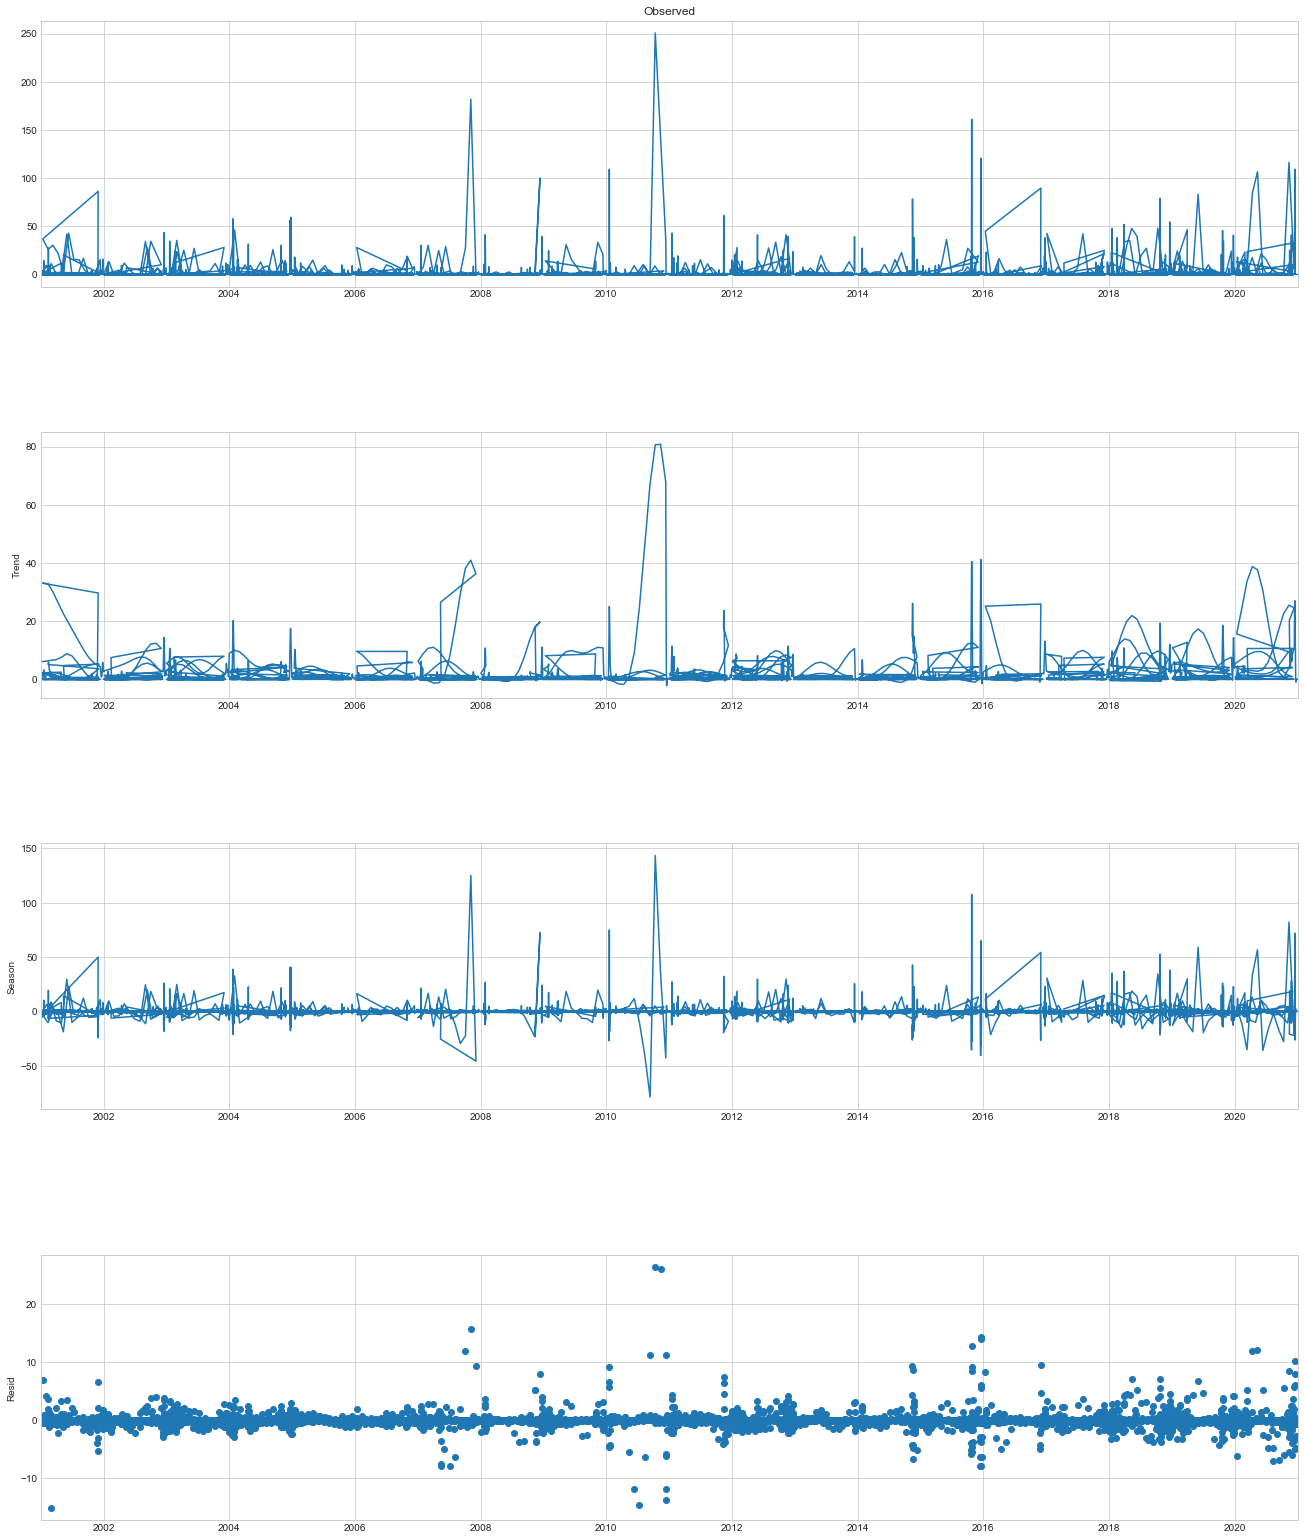

In [237]:
stl = STL(df, period=3, seasonal=3)
res = stl.fit()
fig = res.plot()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 25)

### Visually there is no difference  or influence of trend, seasonality or residuals on the data

## (6) Checking for Auto Correlation 
### Time Series must have auto correlation to work in a forcatsitn model
#### Using ACF - Auto Correlation Function and PACF - Partial ACF

### (6.1) Checking ACF and PCF for Relevant Lag

#### (6.1.1) ACF

In [280]:
#ACF and PACF plots:
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

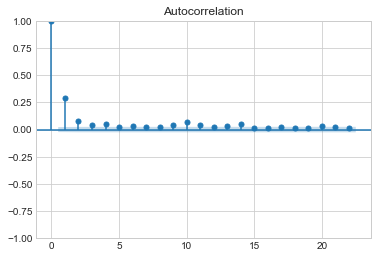

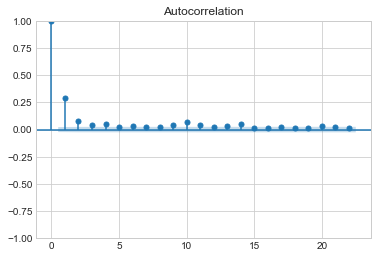

In [281]:
plot_acf(df, lags=22)
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(20, 20)

##### ( Created two graphs; one for AR -Aouto regretion model , one for MA - Moving Avarege modle)

##### (making it bigger to be able to detect the right lag)

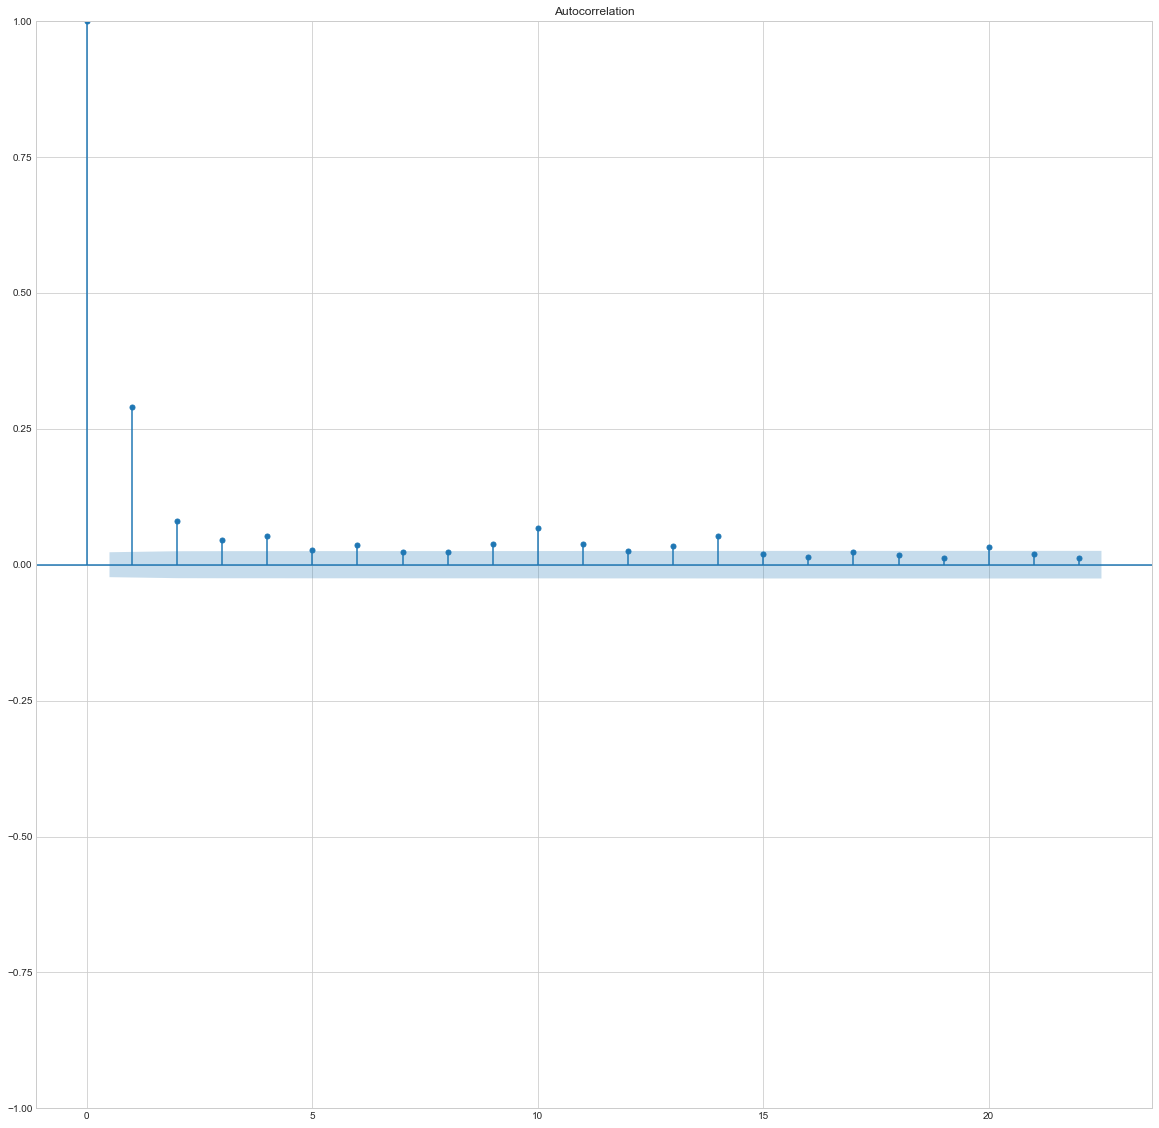

In [282]:
plot_acf(df, lags=22)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)

### Counting the valuse above the p-value line (in light blow) 5 or 6 Lag is good

#### (6.1.2) PACF

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


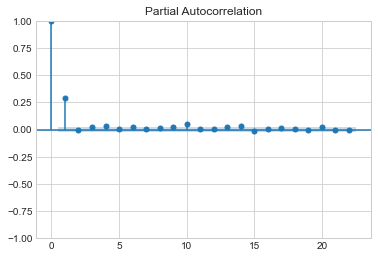

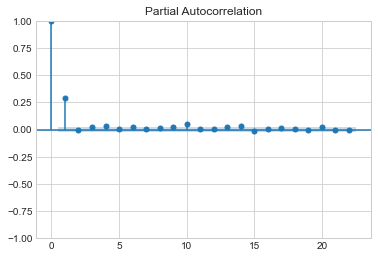

In [193]:
plot_pacf(df, lags=22)
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(20, 20)

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


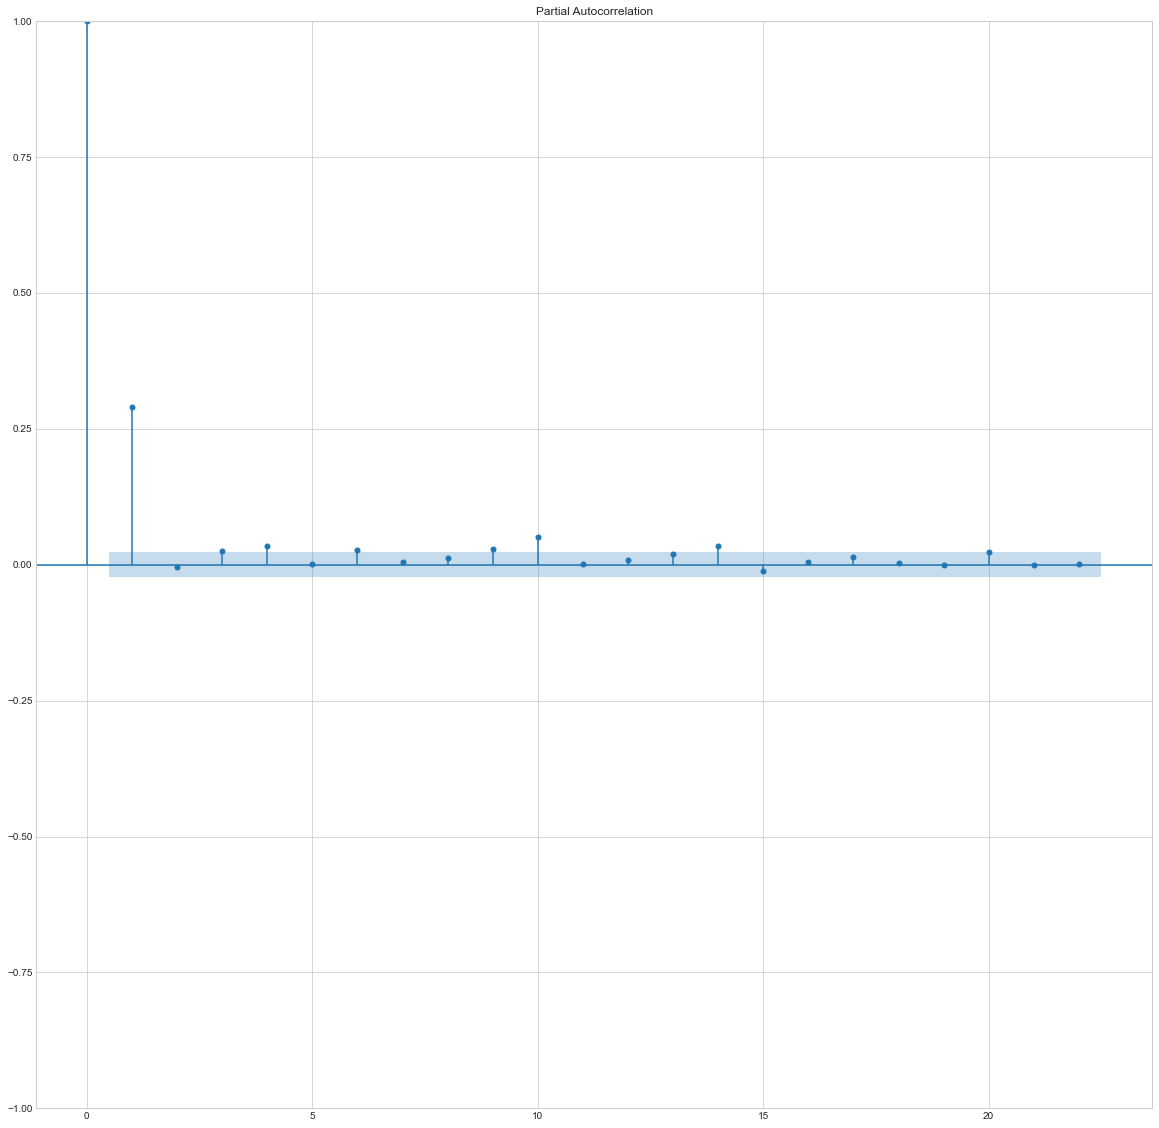

In [277]:
plot_pacf(df, lags=22)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)

### Counting the valuse above the p-value line (in light blow) 2 or 5 are good

## (7) Stationarity tests 
### Time Series data mast be statinary to be used in models

### (7.1) ADF - Ad Fuller Test.

In [156]:
### Auto-correlation test (Ljung-Box white-noise test)
import statsmodels.api as sm

In [157]:
from statsmodels.tsa.stattools import adfuller

In [158]:
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -13.907136717495728
n_lags: 5.596193983012388e-26
p-value: 5.596193983012388e-26
Critial Values:
   1%, -3.4312485724269246
Critial Values:
   5%, -2.8619370992237503
Critial Values:
   10%, -2.566981371682919


##### ADF = -13.9   <  Cr Va   -2.5 , -2.8 , -3.43
##### Lag number = 5.97e-5 
##### P-Vlaue = 5.97e-5     < 0.05 & 0.01
### -----  The time series is stationary -----
##### Criticla Values :
##### -2.56 (10%)
##### -2.86 (5%)
##### -3.43 (1%)

### (7.2) KPSS Test 

In [159]:
import statsmodels.api as sm

In [160]:
sm.tsa.stattools.kpss(df, regression='c')

(0.3812016865401329,
 0.08525789373270133,
 25,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

##### KPSS = 0.38  >  Cr Va 0.347 , 0.46, 0.57 , 0.73 
##### P-value = 0.08  > 0.05 & 0.01
### -----   Time Series is stationary  ------
##### Lag = 25,  
##### Critical Values are at: 
#####                                      0.347 (10%), 
#####                                      0.463 (5%), 
#####                                      0.574 (2.5%), 
#####                                      0.739 (1%), 

## (8) Useing ARIMA  Model on the raw data
#### AR and MA combined test

### (8.1) Using Statsmodel Library

In [191]:
### ARIMA 
from statsmodels.tsa.arima_model import ARIMA

#### (Using ARIMA - (5,0,0) -  AR=5 from 6.1 I=0 & MA=0 in 6.2 too close to the 1 )

In [283]:
mod = sm.tsa.arima.ARIMA(df, order=(5, 0, 0))
res = mod.fit()
print(res.summary())


C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

                               SARIMAX Results                                
Dep. Variable:         day_acu_precip   No. Observations:                 7305
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -24782.154
Date:                Mon, 10 Apr 2023   AIC                          49578.309
Time:                        14:08:27   BIC                          49626.583
Sample:                             0   HQIC                         49594.908
                               - 7305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3279      0.226      5.868      0.000       0.884       1.771
ar.L1          0.2910      0.002    124.536      0.000       0.286       0.296
ar.L2         -0.0112      0.009     -1.193      0.2

### we have ar.L1 to ar.L5  coefficients where only L1 and L4 have P_Values are <0.05

#### (8.1.1) Try to fit the model just for checking visually

In [205]:
results_AR = mod.fit()

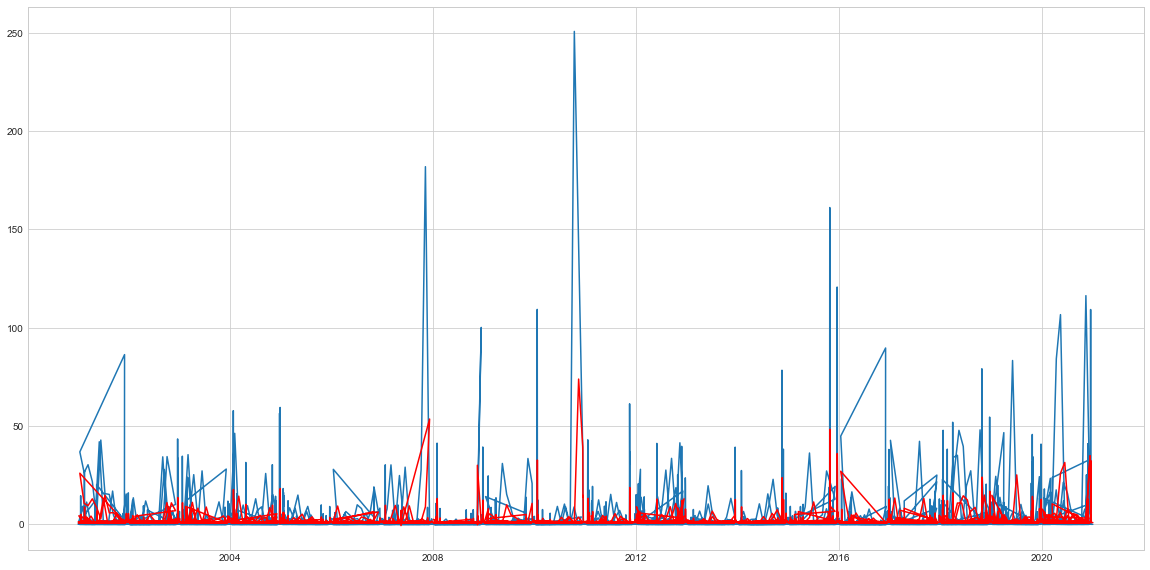

In [207]:
plt.plot(df)
plt.plot(results_AR.fittedvalues, color='red')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

#### The red line is the fit -  not too bad

### (8.2) Checking the Auto ARIMA model on the raw data for comparasion later
#### Using PmdARIMA Library

In [186]:
#!pip install pmdarima

In [187]:
#import pmdarima as pmd
#from pmdarima.arima import auto_arima

In [166]:
def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

In [167]:
arima_model = arimamodel(df)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=49586.056, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=50227.564, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=49584.205, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=49624.648, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50449.384, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=49586.082, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=49587.725, Time=3.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49702.320, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 5.241 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7305
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -24789.103
Date:                Mon, 10 Apr 2023   AIC                          49584.205
Time:                        11:18:02   BIC                          49604.894
Sample:                             0   HQIC                         49591.319
                               - 7305                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9419      0.147      6.421      0.000       0.654       1.229
ar.L1          0.2908      0.002    126.434      0.000       0.286       0.295
sigma2        51.8900      0.109    477.318      0.000      51.677      52.103
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):          34225056.37
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            14.33
Prob(H) (two-sided):                  0.00   Kurtosis:                       337.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Best Model found ARIMA(1,0,0) - AR =1,  AR.L1 Coef = 0.2908  P_Value < 0.01

## (9) Ljung-Box test  to determin autocorelation 

### (9.1) For Lag = 1

In [209]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(df, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,618.003046,2.032771e-136


##### Ljung-Boxs test - P-Value = 2.0e-136 < 0.01 -- > reject the null hypothesis, indicating the time series does contain an autocorrelation

### (9.2) For Lag = 25 (From KPSS test above)

In [190]:
acorr_ljungbox(df, lags=[25], return_df=True)

,lb_stat,lb_pvalue
25,883.412009,2.909102e-170


#####   Ljung-Box test - P-Value = 2.9e-170 < 0.01  --> indicating the time series does contain an autocorrelation.

In [177]:
#from statsmodels.tsa.api import SARIMAX, AutoReg
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.arima.model import ARMA
#from statsmodels.tsa.arima.model import auto_arima

## (10) Diferencing
#### To transform a non-stationary time series into a stationary one 
#### we have stationarity... but just in case

In [239]:
from pmdarima.arima.utils import ndiffs

### (10.1) General ADF test

In [242]:
# determine the number of differences required
d = ndiffs(df, test='adf')
print('The number of differences required to make the time series stationary is:', d)


The number of differences required to make the time series stationary is: 0


### (10.2) Testing diferent seasonal differencings

### (10.2.1)
## Period = 1

#### Applying the diff function

In [243]:
seasdiff_Pr1=df.diff(periods=1)
seasdiff_Pr1

,day_acu_precip
date,
2001-01-01,NaN
2001-02-01,8.961748
2001-03-01,-9.049679
2001-04-01,0.057418
2001-05-01,0.446927
...,...
2020-12-27,0.000000
2020-12-28,0.004954
2020-12-29,-0.004954


#### Visuatization

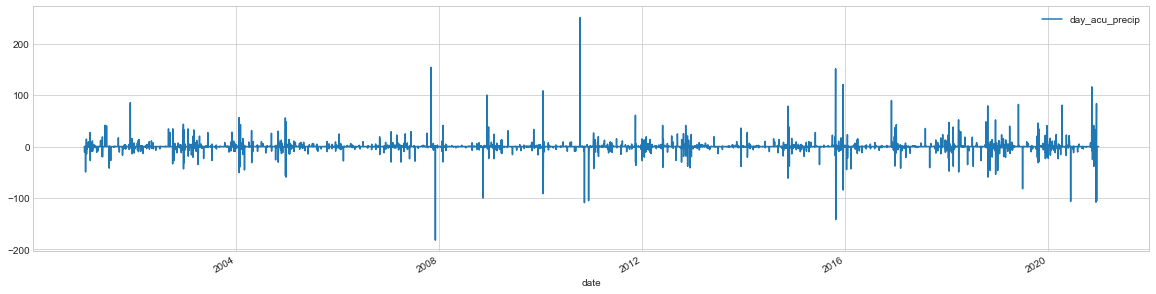

In [244]:
seasdiff_Pr1.plot(label='seasonality difference')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 5)

#### Box Test - Chcking that the autocorrelation is good

In [248]:
acorr_ljungbox(seasdiff_Pr1[1:7305], lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,905.025133,7.932690e-199


#### Applying the ARIMA model 

In [253]:
arima_model_Pr1 = arimamodel(seasdiff_Pr1[1:7305])
arima_model_Pr1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=49582.528, Time=1.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52774.600, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51810.810, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50072.919, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52772.600, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=49580.796, Time=1.91 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=51206.477, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=49582.458, Time=2.72 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=49583.454, Time=4.57 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=49580.677, Time=2.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=49594.882, Time=1.28 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=49583.138, Time=3.15 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=49580.863, Time=1.99 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=49577.687, Time=2.72 sec
 ARIMA(3,0,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7304
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -24781.805
Date:                Mon, 10 Apr 2023   AIC                          49575.610
Time:                        12:34:34   BIC                          49616.987
Sample:                             0   HQIC                         49589.837
                               - 7304                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7994      0.037    -21.736      0.000      -0.871      -0.727
ar.L2          0.1335      0.041      3.258      0.001       0.053       0.214
ma.L1          0.0926      0.037      2.513      0.012       0.020       0.165
ma.L2         -0.9178      0.036    -25.297      0.000      -0.989      -0.847
ma.L3         -0.1311      0.036     -3.605      0.000      -0.202      -0.060
sigma2        51.8086      0.068    757.064      0.000      51.674      51.943
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          34679703.85
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            14.27
Prob(H) (two-sided):                  0.00   Kurtosis:                       339.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Conclusions:
### For Difference Lag =1 :
#### ARIMA Model is (2,0,3) :
#### 2 AR coef's { AR.L1 = -0.799, AR.L2 = 0.133}  
#### 3 MA coef's { MA.L1 = -0.9178 , MA.L2 = -0.917, MA.L3 = -0.131} 
#### All P-Value <0.05

#### fitting the model on the season differenced data

In [259]:
mod_Pr1 = sm.tsa.arima.ARIMA(seasdiff_Pr1, order=(2, 0, 3))
res_Pr1 = mod_Pr1.fit()
print(res_Pr1.summary())


C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

                               SARIMAX Results                                
Dep. Variable:         day_acu_precip   No. Observations:                 7305
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -24781.842
Date:                Mon, 10 Apr 2023   AIC                          49577.685
Time:                        12:50:02   BIC                          49625.959
Sample:                             0   HQIC                         49594.284
                               - 7305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.004      0.150      0.881      -0.008       0.009
ar.L1         -0.7839      0.041    -19.016      0.000      -0.865      -0.703
ar.L2          0.1297      0.043      3.052      0.0

In [261]:
results_AR_Pr1 = mod_Pr1.fit()

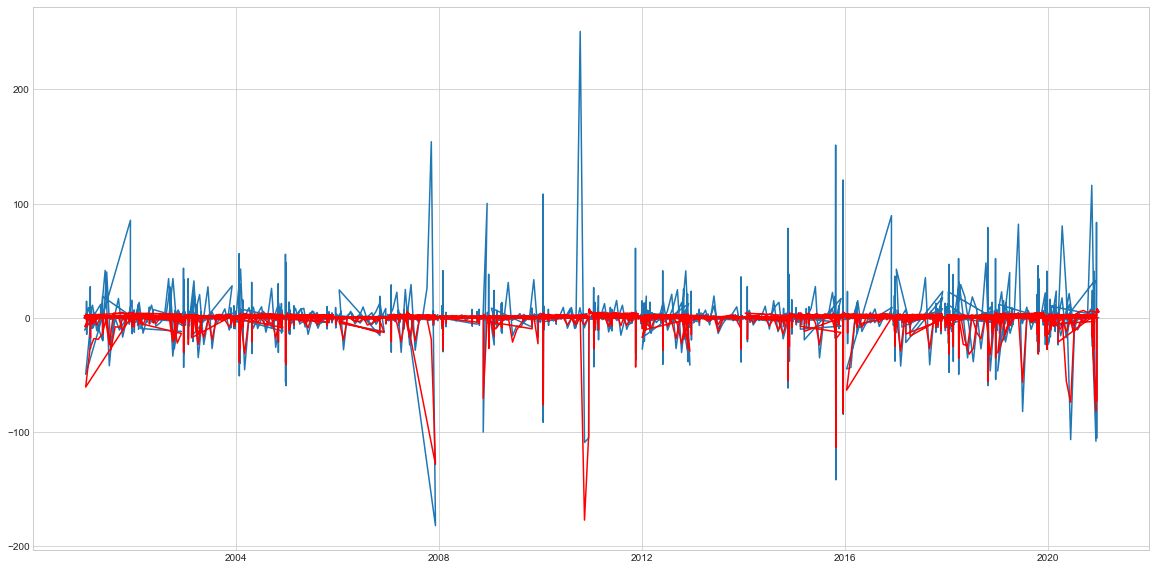

In [262]:
plt.plot(seasdiff_Pr1)
plt.plot(results_AR_Pr1.fittedvalues, color='red')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

### (10.2.2)
## Period = 25

#### Applying the diff function

In [249]:
seasdiff_Pr25=df.diff(periods=25)
seasdiff_Pr25

,day_acu_precip
date,
2001-01-01,NaN
2001-02-01,NaN
2001-03-01,NaN
2001-04-01,NaN
2001-05-01,NaN
...,...
2020-12-27,-10.759238
2020-12-28,-3.733940
2020-12-29,-84.135315


#### Visuatization

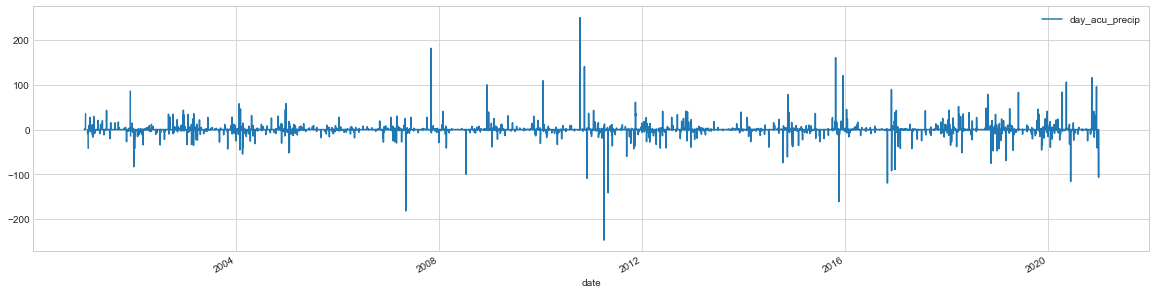

In [251]:
seasdiff_Pr25.plot(label='seasonality difference')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 5)

#### Box Test - Chcking that the autocorrelation is good

In [252]:
acorr_ljungbox(seasdiff_Pr25[26:7305], lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,483.467506,3.760345e-107


#### Applying the ARIMA model 

In [255]:
arima_model_Pr25 = arimamodel(seasdiff_Pr25[26:7305])
arima_model_Pr25.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54358.122, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54856.784, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=54358.741, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=54371.526, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54854.789, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=54359.779, Time=1.60 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=54355.811, Time=1.83 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=54359.539, Time=0.72 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=54357.135, Time=2.95 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=54356.991, Time=3.88 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=54360.754, Time=1.09 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=54310.857, Time=3.70 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=54311.429, Time=5.72 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=54311.649, Time=6.31 sec
 ARIMA(1,0,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7279
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -27148.429
Date:                Mon, 10 Apr 2023   AIC                          54308.858
Time:                        12:42:35   BIC                          54350.215
Sample:                             0   HQIC                         54323.081
                               - 7279                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2141      0.136     -1.572      0.116      -0.481       0.053
ar.L2          0.7515      0.131      5.716      0.000       0.494       1.009
ma.L1          0.4845      0.136      3.560      0.000       0.218       0.751
ma.L2         -0.6472      0.172     -3.757      0.000      -0.985      -0.310
ma.L3         -0.1804      0.043     -4.239      0.000      -0.264      -0.097
sigma2       101.6381      0.192    530.336      0.000     101.262     102.014
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           9124778.72
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                       176.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Conclusions:
### For Difference Lag =25 :
#### ARIMA Model is (2,0,3) :
#### 2 AR coef's { AR.L1 = -0.2141 ! P-Value = 0.116 , AR.L2 = 0.7515}  
#### 3 MA coef's { MA.L1 = 0.4845 , MA.L2 = -0.6472, MA.L3 = -0.1804} 
#### All other P-Value <0.05

#### fitting the model on the season differenced data

In [260]:
mod_Pr25 = sm.tsa.arima.ARIMA(seasdiff_Pr25, order=(2, 0, 3))
res_Pr25 = mod_Pr25.fit()
print(res_Pr25.summary())

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

                               SARIMAX Results                                
Dep. Variable:         day_acu_precip   No. Observations:                 7305
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -27151.677
Date:                Mon, 10 Apr 2023   AIC                          54317.354
Time:                        12:51:18   BIC                          54365.629
Sample:                             0   HQIC                         54333.953
                               - 7305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0087      0.181      0.048      0.962      -0.346       0.363
ar.L1         -0.2148      0.137     -1.565      0.118      -0.484       0.054
ar.L2          0.7508      0.132      5.678      0.0

In [264]:
results_AR_Pr25 = mod_Pr25.fit()

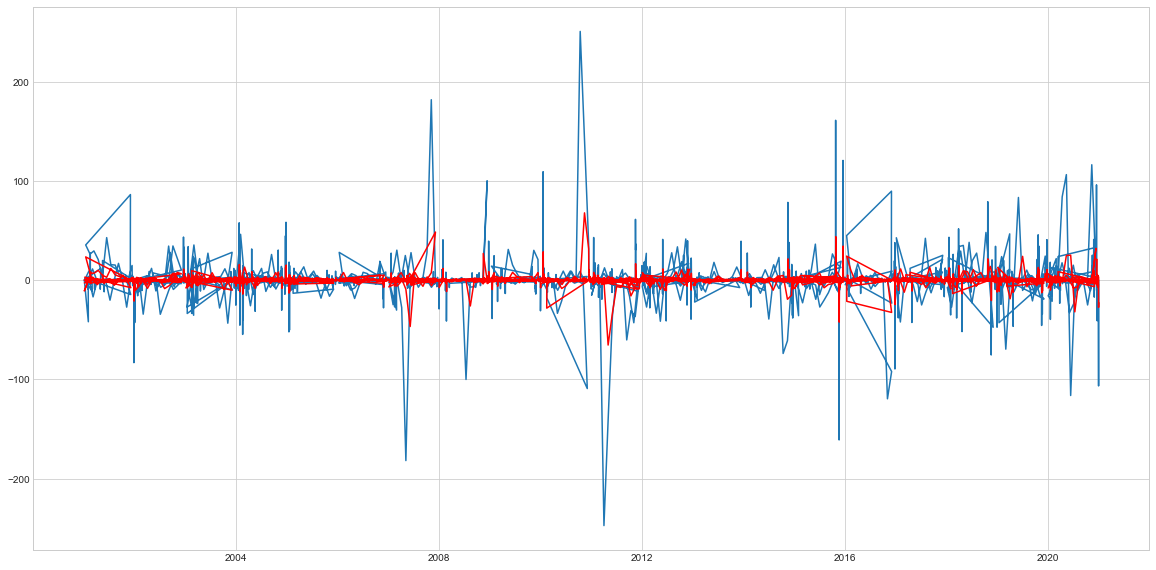

In [265]:
plt.plot(seasdiff_Pr25)
plt.plot(results_AR_Pr25.fittedvalues, color='red')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

### (10.2.3)
## Period = 365

#### Applying the diff function

In [266]:
seasdiff_Pr365=df.diff(periods=365)
seasdiff_Pr365

,day_acu_precip
date,
2001-01-01,NaN
2001-02-01,NaN
2001-03-01,NaN
2001-04-01,NaN
2001-05-01,NaN
...,...
2020-12-27,-2.321458
2020-12-28,-2.821939
2020-12-29,-6.987041


#### Visuatization

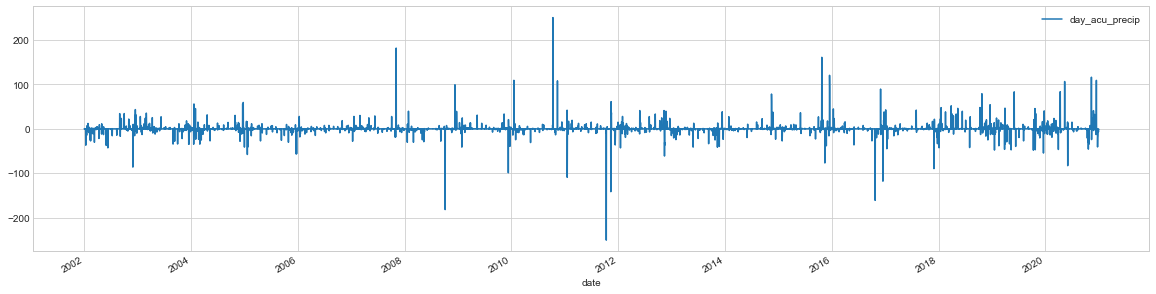

In [267]:
seasdiff_Pr365.plot(label='seasonality difference')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 5)

#### Box Test - Chcking that the autocorrelation is good

In [269]:
acorr_ljungbox(seasdiff_Pr365[366:7305], lags=[365], return_df=True)

,lb_stat,lb_pvalue
365,2531.331698,0.0


#### Applying the ARIMA model 

In [271]:
arima_model_Pr365 = arimamodel(seasdiff_Pr365[366:7305])
arima_model_Pr365.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=51633.558, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=52137.146, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51635.832, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=51647.354, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52135.289, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=51635.557, Time=1.93 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=51635.569, Time=0.96 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=51633.686, Time=0.64 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=51633.643, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=51637.552, Time=1.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=51631.644, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=51645.451, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51633.915, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=51633.644, Time=0.81 sec
 ARIMA(1,0,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6939
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -25812.822
Date:                Mon, 10 Apr 2023   AIC                          51631.644
Time:                        13:05:58   BIC                          51652.179
Sample:                             0   HQIC                         51638.724
                               - 6939                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1772      0.040      4.415      0.000       0.099       0.256
ma.L1          0.0939      0.041      2.300      0.021       0.014       0.174
sigma2        99.7228      0.180    553.276      0.000      99.370     100.076
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          10135895.47
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                       190.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Conclusions:
### For Difference Lag =365 :
#### ARIMA Model is (1,0,1) :
#### 1 AR coef's { AR.L1 =  0.1772 }  
#### 1 MA coef's { MA.L1 = 0.0939 } 
#### All  P-Value <0.05

#### fitting the model on the season differenced data

In [272]:
mod_Pr365 = sm.tsa.arima.ARIMA(seasdiff_Pr365, order=(1, 0, 1))
res_Pr365 = mod_Pr365.fit()
print(res_Pr365.summary())

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

                               SARIMAX Results                                
Dep. Variable:         day_acu_precip   No. Observations:                 7305
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -25816.007
Date:                Mon, 10 Apr 2023   AIC                          51640.015
Time:                        13:08:01   BIC                          51667.600
Sample:                             0   HQIC                         51649.500
                               - 7305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0470      0.161      0.292      0.770      -0.269       0.363
ar.L1          0.1772      0.041      4.371      0.000       0.098       0.257
ma.L1          0.0939      0.041      2.278      0.0

In [273]:
results_AR_Pr365 = mod_Pr365.fit()

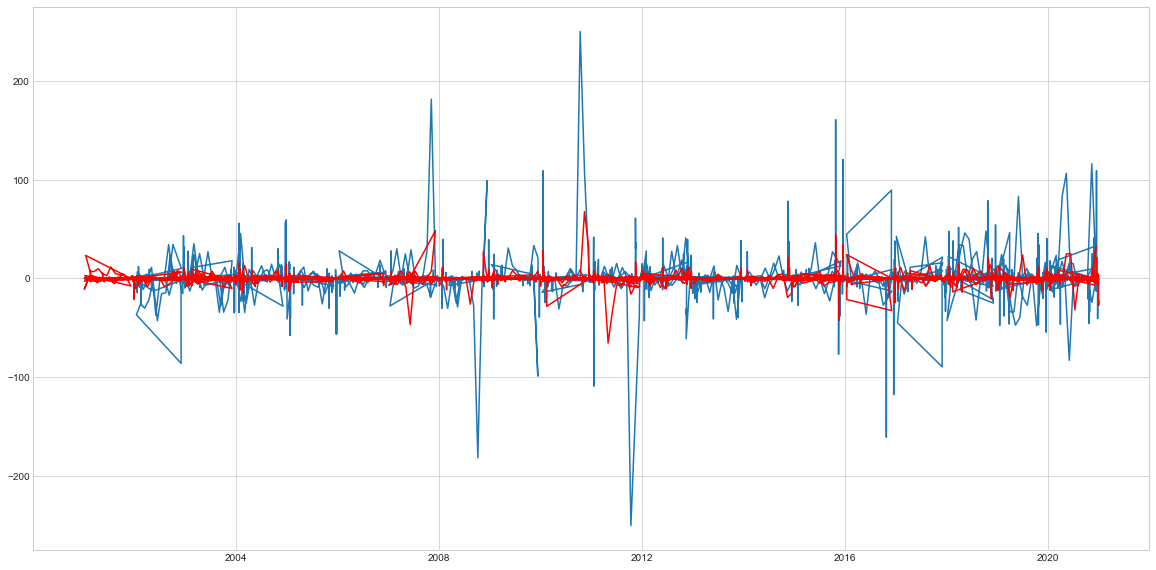

In [274]:
plt.plot(seasdiff_Pr365)
plt.plot(results_AR_Pr25.fittedvalues, color='red')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

## (11) Train Test the model

### for Lag = 25

### (11.1.1) Copy tested data frame chosen to a Training Testing data frame

In [304]:
DF_MOD=seasdiff_Pr25[26:7305]

In [287]:
DF_MOD.to_csv('Mefalsim_preciption_2001-2020_MOD.csv')

In [305]:
DF_MOD

,day_acu_precip
date,
2001-01-27,-9.049679
2001-01-28,0.000000
2001-01-29,-0.057418
2001-01-30,-0.504346
2001-01-31,-41.955627
...,...
2020-12-27,-10.759238
2020-12-28,-3.733940
2020-12-29,-84.135315


### (11.1.2) Plot the data

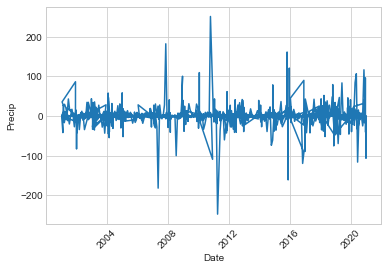

In [306]:
plt.ylabel('Precip')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(DF_MOD.index, DF_MOD['day_acu_precip'], )

### (11.1.3) Train Test  & Plot  befor and after 2019

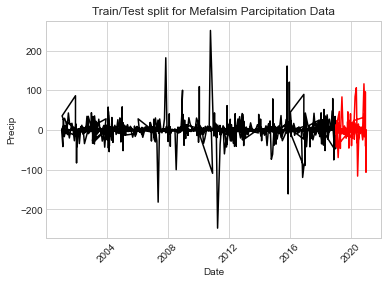

In [307]:
train = DF_MOD[DF_MOD.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = DF_MOD[DF_MOD.index > pd.to_datetime("2019-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Precip')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Mefalsim Parcipitation Data")
plt.show()

### (11.1.4) Use Seasonal ARIMA

In [297]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [308]:
y = train['day_acu_precip']

### (11.1.5) Apply model

In [318]:
ARMAmodel = SARIMAX(y, order = (2, 0, 3))

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

### (11.1.6) Fit Model

In [319]:
ARMAmodel = ARMAmodel.fit()

In [320]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


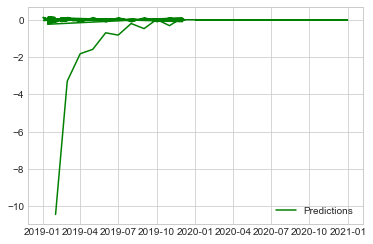

In [321]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

### (11.1.7) Check Accuracy RMSE Metrics

In [322]:
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["day_acu_precip"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  13.164084883533183


# For SARIMA (2,0,3) Lag = 25, Model  RMSE = 13.164

### for Lag = 365

### (11.2.1) Copy tested data frame chosen to a Training Testing data frame

In [323]:
DF_MOD_365=seasdiff_Pr365[366:7305]

In [332]:
DF_MOD_365.to_csv('Mefalsim_preciption_2001-2020_MOD_365.csv')

In [324]:
DF_MOD_365

,day_acu_precip
date,
2002-02-01,4.423969
2002-03-01,0.000000
2002-04-01,0.718973
2002-05-01,11.352973
2002-06-01,-37.398622
...,...
2020-12-27,-2.321458
2020-12-28,-2.821939
2020-12-29,-6.987041


### (11.2.2) Plot the data

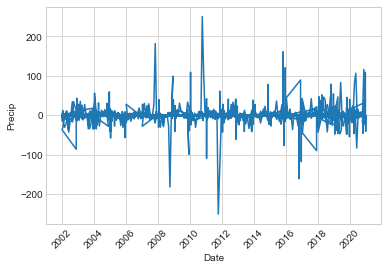

In [325]:
plt.ylabel('Precip')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(DF_MOD_365.index, DF_MOD_365['day_acu_precip'], )

### (11.2.3) Train Test  & Plot  befor and after 2019

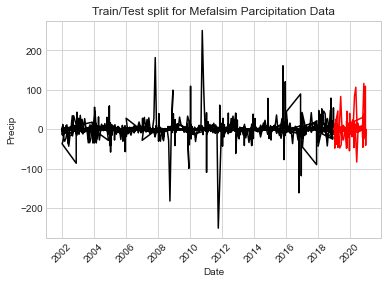

In [326]:
train = DF_MOD_365[DF_MOD_365.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = DF_MOD_365[DF_MOD_365.index > pd.to_datetime("2019-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Precip')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Mefalsim Parcipitation Data")
plt.show()

### (11.2.4) Use Seasonal ARIMA

In [297]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [308]:
y = train['day_acu_precip']

### (11.2.5) Apply model

In [327]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

### (11.2.6) Fit Model

In [328]:
ARMAmodel = ARMAmodel.fit()

In [329]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


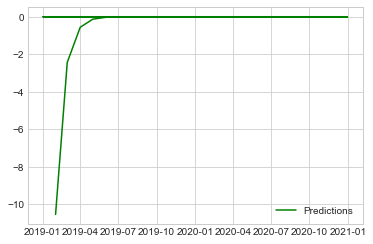

In [330]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

### (11.2.7) Check Accuracy RMSE Metrics

In [331]:
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["day_acu_precip"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  12.432704291129463


# For SARIMA (1,0,1) Lag = 365 Model  RMSE = 12.432

### for Lag = 1

### (11.3.1) Copy tested data frame chosen to a Training Testing data frame

In [333]:
DF_MOD_1=seasdiff_Pr1[1:7305]

In [334]:
DF_MOD_1.to_csv('Mefalsim_preciption_2001-2020_MOD_1.csv')

In [335]:
DF_MOD_1

,day_acu_precip
date,
2001-02-01,8.961748
2001-03-01,-9.049679
2001-04-01,0.057418
2001-05-01,0.446927
2001-06-01,41.451281
...,...
2020-12-27,0.000000
2020-12-28,0.004954
2020-12-29,-0.004954


### (11.3.2) Plot the data

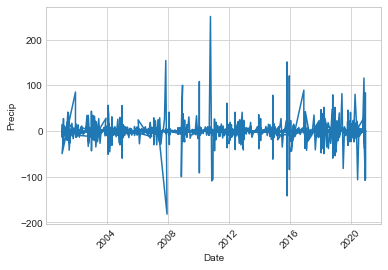

In [336]:
plt.ylabel('Precip')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(DF_MOD_1.index, DF_MOD_1['day_acu_precip'], )

### (11.3.3) Train Test  & Plot  befor and after 2019

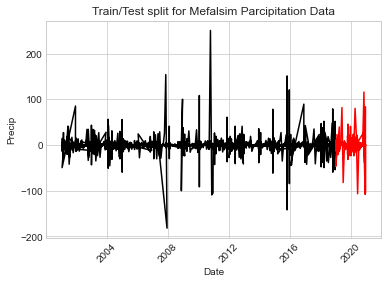

In [337]:
train = DF_MOD_1[DF_MOD_1.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = DF_MOD_1[DF_MOD_1.index > pd.to_datetime("2019-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Precip')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Mefalsim Parcipitation Data")
plt.show()

### (11.3.4) Use Seasonal ARIMA

In [297]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [338]:
y = train['day_acu_precip']

### (11.3.5) Apply model

In [339]:
ARMAmodel = SARIMAX(y, order = (2, 0, 3))

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

### (11.3.6) Fit Model

In [340]:
ARMAmodel = ARMAmodel.fit()

In [341]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\שם גולסט\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


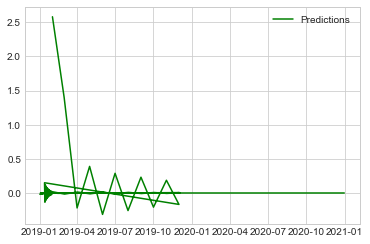

In [342]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

### (11.2.7) Check Accuracy RMSE Metrics

In [343]:
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["day_acu_precip"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  11.974249508329812


# For SARIMA (2,0,3) Lag = 1 Model  RMSE = 11.974

# ------------------------------------

# Best Model according to RMSE .... SARIMA (2,0,3) Lag = 1

 #### SARIMAX Results                                
=============================================================================
Dep. Variable:         day_acu_precip   No. Observations:                 7305
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -24781.842
Date:                Mon, 10 Apr 2023   AIC                          49577.685
Time:                        12:50:02   BIC                          49625.959
Sample:                             0   HQIC                         49594.284
                               - 7305                                         
#### Covariance Type:                  opg                                         
==============================================================================
####                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.004      0.150      0.881      -0.008       0.009
ar.L1         -0.7839      0.041    -19.016      0.000      -0.865      -0.703
ar.L2          0.1297      0.043      3.052      0.002       0.046       0.213
ma.L1          0.0770      0.041      1.871      0.061      -0.004       0.158
ma.L2         -0.9024      0.044    -20.588      0.000      -0.988      -0.817
ma.L3         -0.1314      0.037     -3.561      0.000      -0.204      -0.059
#### sigma2        51.8082      0.115    452.178      0.000      51.584      52.033
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          34693040.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            14.28
#### Prob(H) (two-sided):                  0.00   Kurtosis:                       339.40
===================================================================================

# The Formula for Percipitation most probable forcast 
## for current day is:
#### Yt = (-0.7839)Xt-1 + (0.0770)Xt-1  + (0.1297)Xt-2 + (-0.9024)Xt-2 + (-0.1314)Xt-3 + 0.0006
##  Tomorrow   is:
#### Yt+1 = (-0.7839)Xt + (0.0770)Xt  + (0.1297)Xt-1 + (-0.9024)Xt-1 + (-0.1314)Xt-2 + 0.0006
# ...